In [ ]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from sklearn.datasets import make_classification
from sklearn.metrics import classification_report,confusion_matrix, roc_curve, roc_auc_score, auc, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import ShuffleSplit,train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize, StandardScaler, MinMaxScaler

In [ ]:
'''
輸入資料
'''
import pandas as pd
from scipy.io import arff

dataset = pd.read_csv('/content/german.data')

'''
欄位前處理
'''
dataset = dataset[dataset.columns[0]].str.split(' ',expand=True)

'''
更換欄位名稱
'''
dataset.columns = ['ExistingCheckingAccount', 'Duration_month', 'CreditHistory', 'Purpose', 'CreditAmount',
         'SavingsAccount', 'EmploymentSince', 'InstallmentRate_DisposableIncome', 'StatusAndSex', 'OtherDebtors',
         'ResidenceSince', 'Property', 'Age_year', 'OtherInstallmentPlans', 'Housing',
         'ExistingCredits', 'Job', 'PeopleLiable', 'Telephone', 'ForeignWorker', 'Classification']

numAttribute = ['ExistingCheckingAccount', 'CreditHistory', 'Purpose', 'SavingsAccount', 'EmploymentSince',
           'StatusAndSex', 'OtherDebtors', 'Property', 'OtherInstallmentPlans', 'Housing', 'Job',
           'Telephone', 'ForeignWorker']
qualiAttribute = ['CreditAmount', 'Duration_month', 'InstallmentRate_DisposableIncome', 'ResidenceSince', 'Age_year',
           'ExistingCredits', 'PeopleLiable', 'Classification']

for j in range(len(qualiAttribute)):
    dataset[qualiAttribute[j]] = pd.to_numeric(dataset[qualiAttribute[j]])
print(dataset.head())

'''
Label encoding編碼
'''
from sklearn.preprocessing import LabelEncoder

dataset_origin = dataset
print(dataset_origin.head())

labelencoder = LabelEncoder()
for i in range(len(numAttribute)):
    print('before: ', numAttribute[i],": ", dataset_origin[numAttribute[i]].unique())
    dataset[numAttribute[i]] = labelencoder.fit_transform(dataset[numAttribute[i]])
    print('afer: ', numAttribute[i],": ", dataset[numAttribute[i]].unique())
print(dataset.head())

dataset.Classification.replace([1,2], [1,0], inplace=True)

  ExistingCheckingAccount  Duration_month CreditHistory Purpose  CreditAmount  \
0                     A12              48           A32     A43          5951   
1                     A14              12           A34     A46          2096   
2                     A11              42           A32     A42          7882   
3                     A11              24           A33     A40          4870   
4                     A14              36           A32     A46          9055   

  SavingsAccount EmploymentSince  InstallmentRate_DisposableIncome  \
0            A61             A73                                 2   
1            A61             A74                                 2   
2            A61             A74                                 2   
3            A61             A73                                 3   
4            A65             A73                                 2   

  StatusAndSex OtherDebtors  ...  Property Age_year  OtherInstallmentPlans  \
0          A92

In [ ]:
interval = (18, 40, 60, 120)

cats = [0, 1, 2]
dataset["Age Category"] = pd.cut(dataset.Age_year, interval, labels=cats)

dataset["Age Category"] = pd.to_numeric(dataset["Age Category"])

print(dataset["Age Category"])

0      0
1      1
2      1
3      1
4      0
      ..
994    0
995    0
996    0
997    0
998    0
Name: Age Category, Length: 999, dtype: int64


In [ ]:
interval = (1,24,100)

cats = [0, 1]
dataset["Duration_month"] = pd.cut(dataset.Duration_month, interval, labels=cats)
dataset["Duration_month"] = pd.to_numeric(dataset["Duration_month"])

In [ ]:
dataset_train = dataset[:900]
dataset_test= dataset[900:]
print(dataset_train)

     ExistingCheckingAccount  Duration_month  CreditHistory  Purpose  \
0                          1               1              2        4   
1                          3               0              4        7   
2                          0               1              2        3   
3                          0               0              3        0   
4                          3               1              2        7   
..                       ...             ...            ...      ...   
895                        0               0              2        4   
896                        3               0              4        3   
897                        3               0              2        3   
898                        0               0              2        3   
899                        0               0              4        0   

     CreditAmount  SavingsAccount  EmploymentSince  \
0            5951               0                2   
1            2096          

In [ ]:
from imblearn.over_sampling import BorderlineSMOTE, SMOTE, ADASYN

X = dataset_train.drop('Classification', axis=1)
y = dataset_train['Classification']

X_test = dataset_test.drop('Classification', axis=1)
y_test = dataset_test['Classification']
print(pd.isna(X))
#X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=1)

# Apply SMOTE

sm = SMOTE(sampling_strategy='minority')
#sm = SMOTE(sampling_strategy='minority')
X_train_s, y_train_s = sm.fit_resample(X, y)

print("Before/After clean")
unique, counts = np.unique(y, return_counts=True)
print(dict(zip(unique, counts)))
unique, counts = np.unique(y_train_s, return_counts=True)
print(dict(zip(unique, counts)))

     ExistingCheckingAccount  Duration_month  CreditHistory  Purpose  \
0                      False           False          False    False   
1                      False           False          False    False   
2                      False           False          False    False   
3                      False           False          False    False   
4                      False           False          False    False   
..                       ...             ...            ...      ...   
895                    False           False          False    False   
896                    False           False          False    False   
897                    False           False          False    False   
898                    False           False          False    False   
899                    False           False          False    False   

     CreditAmount  SavingsAccount  EmploymentSince  \
0           False           False            False   
1           False          

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold

print(' with grid search')
# play with these params
params={
    'max_depth': [3, 5, 7, 9],
    'n_estimators': [50, 100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion' :['gini', 'entropy', 'log_loss']
}

kfold = KFold(n_splits=10, shuffle=True, random_state=42)

model = RandomForestClassifier()

rs = GridSearchCV(model,
                  params,
                  cv=kfold,
                  scoring="roc_auc",
                  verbose=False)

rs.fit(X_train_s, y_train_s)


print("最佳参数组合：", rs.best_params_)
print("最佳模型得分：", -rs.best_score_)

best_model =  rs.best_estimator_

# 在测试数据上进行预测
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:,1] #model.best_iteration

print ('\n')
print ("Model Final Generalization roc_auc_score: %.6f" %roc_auc_score(y_test,y_pred_proba))
print ("Model Final Generalization ACC: %.6f" %accuracy_score(y_test,y_pred))
print ("Model Final Generalization F1: %.6f" %f1_score(y_test,y_pred))
print ("Model Final Generalization precision: %.6f" %precision_score(y_test,y_pred))
print ("Model Final Generalization recall: %.6f" %recall_score(y_test,y_pred))

 with grid search


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor

最佳参数组合： {'criterion': 'gini', 'max_depth': 9, 'max_features': 'sqrt', 'n_estimators': 500}
最佳模型得分： -0.9008139097335219


Model Final Generalization roc_auc_score: 0.823529
Model Final Generalization ACC: 0.787879
Model Final Generalization F1: 0.834646
Model Final Generalization precision: 0.898305
Model Final Generalization recall: 0.779412


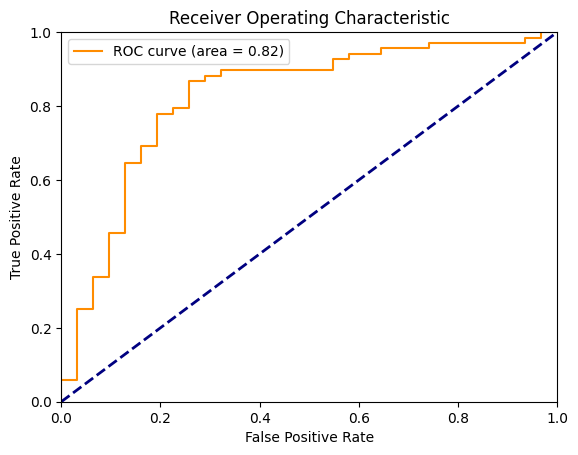



Accuracy score of the model 0.7878787878787878
Classification report 

              precision    recall  f1-score   support

           0       0.62      0.81      0.70        31
           1       0.90      0.78      0.83        68

    accuracy                           0.79        99
   macro avg       0.76      0.79      0.77        99
weighted avg       0.81      0.79      0.79        99



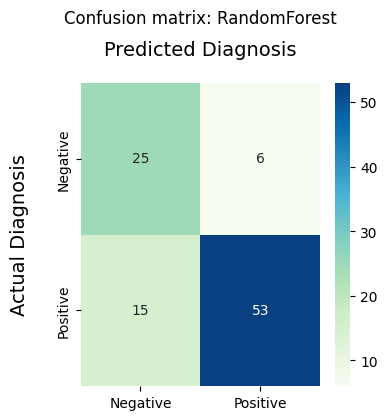

In [ ]:
import seaborn as sns

# Function to get roc curve
def get_roc (y_test,y_pred):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    #Plot of a ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="upper left")
    plt.show()
    return

def model_performance(y_test,y_pred, method):

    # calculate the accruacy of the model
    print("Accuracy score of the model", accuracy_score(y_test,y_pred))
    print("Classification report \n")

    #generate the classification report
    print(classification_report(y_test,y_pred))

    #generate the confusion matrix
    fig = plt.figure(figsize = (4,4))
    ax = fig.gca()
    cnf_matrix_log = confusion_matrix(y_test, y_pred)
    sns.heatmap(pd.DataFrame(cnf_matrix_log), annot=True,cmap="GnBu" , fmt='g')
    ax.xaxis.set_label_position("top")
    ax.xaxis.set_ticklabels(['Negative', 'Positive'])
    ax.yaxis.set_ticklabels(['Negative', 'Positive'])
    ax.set_xlabel("Predicted Diagnosis", fontsize=14, labelpad=20)
    ax.set_ylabel("Actual Diagnosis", fontsize=14, labelpad=20)
    plt.tight_layout()
    plt.title('Confusion matrix: '+  method + '\n', y=1.1)

get_roc (y_test,y_pred_proba)
print('\n')
model_performance(y_test,y_pred, 'RandomForest')